## Adaptive Masking and Out-of-source-domain Masking

To be able to reuse the generated regridding weights on data with nonpermanent masks (eg. land-sea-mask changing for different model levels and time or variable dependent masks) one can use the "Adaptive Masking" approach, as suggested by sraynaud (https://github.com/pangeo-data/xESMF/issues/29#issuecomment-714252254).
This approach requires to not define an input / output mask when generating the regridding weights and
is similar to the "renormalize" option as implemented by Matthew Long (https://github.com/NCAR/esmlab-regrid/blob/master/esmlab_regrid/core.py#L147):
1. Generate conservative remapping weights without specifying any mask
1. Create a mask of the input data field of type float (array of 1./0.)
2. Regrid the mask
3. Regrid the data (while having NaNs filled with 0)
4. Devide the regridded data by the regridded mask (=renormalizing), set to NaN where the regridded mask==0

However, if specifying an input mask when the regridding weights are generated, or, if the destination domain is larger than the source domain, one can mask out-of-source-domain cells by manipulating the regridding weights,
as suggested by Nic Wayand (function "add_matrix_NaNs"): https://github.com/JiaweiZhuang/xESMF/issues/15#issuecomment-371646763

#### Questions that arise for me from the following examples are:
1. Can "adaptive masking" (or a similar adjusted technique) be applied for the bilinear and the patch regridding methods?
2. What causes the (at first glance odd) behavior at the "southern" domain boundary for the bilinear and patch regridding techniques, that introduces missing values in the lowermost row (and only there)?

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
import scipy
import warnings
warnings.simplefilter("ignore")
xr.set_options(display_style='html');

print("Using xESMF in version %s" % xe.__version__)

Using xESMF in version 0.4.0


### Adaptive masking - Downscaling

Cell centers of source grid (left-hand-side) are depicted in blue.
Cell centers of the destination grid (right-hand-side) are depicted in red.

Conservative: Preserves the integral of the source field across the regridding.
For this method, weight calculation is based on the ratio of source cell area
overlapped with the corresponding destination cell area.


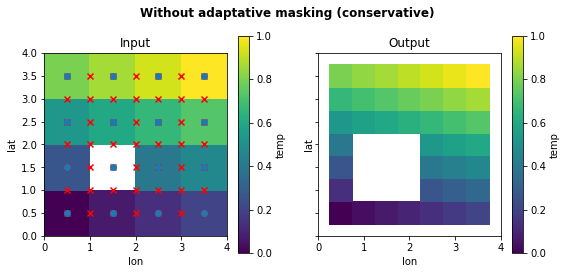

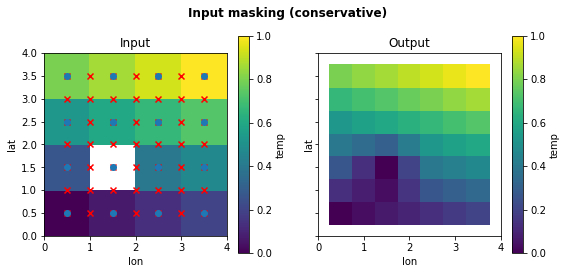

When using the conservative_normed technique and specifying an input mask, a renormalization is applied:


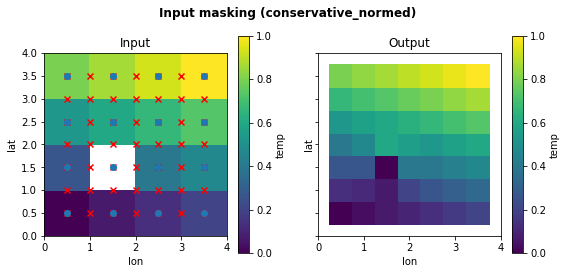

Additionally applying 'add_matrix_NaNs', masks the unwanted 0 values that ESMF returns in that case:


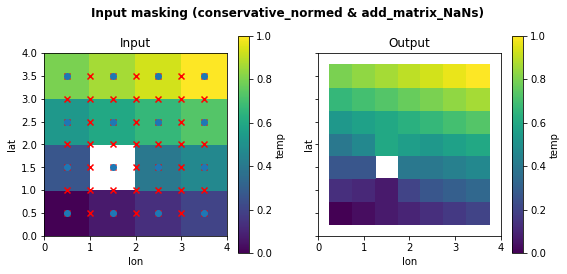

The same result is attained when using 'Adaptive Masking':


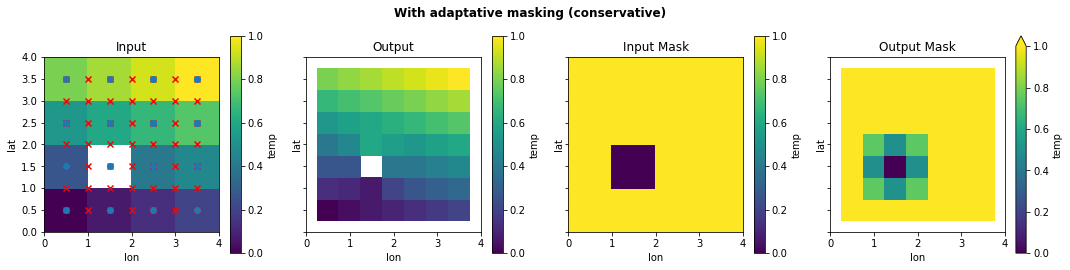

Bilinear: Linear interpolation in 2 or 3 dimensions.


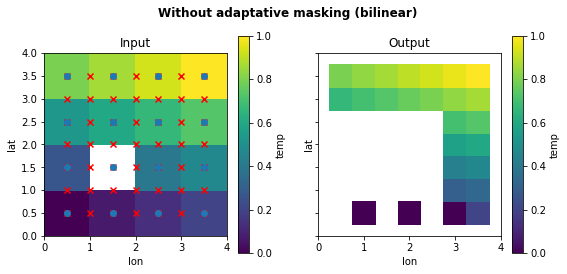

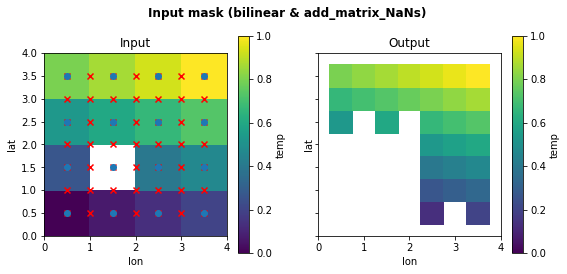

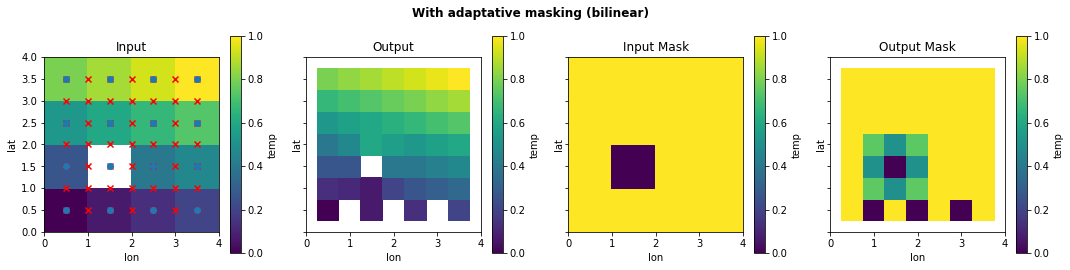

Patch: Patch rendezvous method of taking the least squares fit of the surrounding
surface patches. This is a higher order method that may produce interpolation
weights that may be slightly less than 0 or slightly greater than 1.


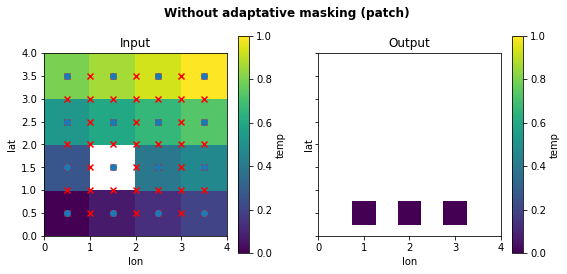

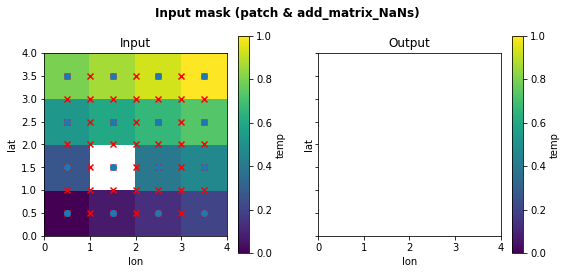

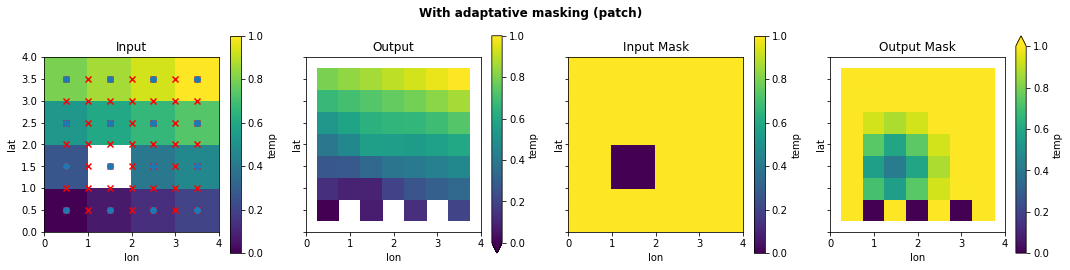

In [2]:
def add_matrix_NaNs(regridder):
    """Add Nans to matrices, which makes any output cell with a weight from a NaN input cell = NaN"""
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    # indptr: https://stackoverflow.com/questions/52299420/scipy-csr-matrix-understand-indptr
    # Creates array with length nrows+1 with information about non-zero values,
    #  with np.diff calculating how many non-zero elements there are in each row
    num_nonzeros = np.diff(M.indptr) 
    # Setting rows with only zeros to NaN
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder


def double_plot(da0, da1, suptitle):
    fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, sharey=True,
                                   subplot_kw={'aspect': 1}, figsize=(9, 4))
    xi,yi = np.meshgrid(da0.lon.values, da0.lat.values)
    xo,yo = np.meshgrid(da1.lon.values, da1.lat.values)
    da0.plot(ax=ax0, add_colorbar=True, vmin=0, vmax=1)
    ax0.set_title('Input')
    #ax0.grid()
    ax0.scatter(xo,yo, marker="x", c="r")    
    ax0.scatter(xi,yi)    
    da1.plot(ax=ax1, add_colorbar=True, vmin=0, vmax=1)
    ax1.set_title('Output')
    #ax1.scatter(xo,yo, marker="x", c="r")  
    #ax1.scatter(xi,yi)
    #ax1.grid()
    plt.axis([0, 4, 0, 4])
    plt.suptitle(suptitle, weight="bold")
    plt.show()

    
def quad_plot(da0, da1, da2, da3, suptitle, title1='Input', title2='Output', title3='Input Mask', title4='Output Mask'):
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, sharex=True, sharey=True,
                                   subplot_kw={'aspect': 1}, figsize=(18, 4))
    xi,yi = np.meshgrid(da0.lon.values, da0.lat.values)
    xo,yo = np.meshgrid(da1.lon.values, da1.lat.values)
    da0.plot(ax=ax0, add_colorbar=True, vmin=0, vmax=1)
    ax0.set_title(title1)
    #ax0.grid()
    ax0.scatter(xo,yo, marker="x", c="r")  
    ax0.scatter(xi,yi)
    da1.plot(ax=ax1, add_colorbar=True, vmin=0, vmax=1)
    ax1.set_title(title2)
    #ax1.scatter(xo,yo, marker="x", c="r")
    #ax1.scatter(xi,yi)
    #ax1.grid()
    da2.plot(ax=ax2, add_colorbar=True, vmin=0, vmax=1)
    ax2.set_title(title3)
    #ax2.grid()
    da3.plot(ax=ax3, add_colorbar=True, vmin=0, vmax=1)
    ax3.set_title(title4)
    #ax3.grid()
    plt.axis([0, 4, 0, 4])
    plt.suptitle(suptitle, weight="bold")
    plt.show()    
  
    
# Input dataset
tempi = np.linspace(0,1,16).reshape(4,4) #np.arange(9).reshape(3, 3)*1.*0+1
tempi[1, 1] = np.nan
dsi = xr.Dataset(
    {'temp': (['lat', 'lon'], tempi),
     'lon_b': ('nxb', [0., 1., 2., 3., 4.]),
     'lat_b': ('nyb', [0., 1., 2., 3., 4.])},
    coords={'lat': [.5, 1.5, 2.5, 3.5], 'lon': [.5, 1.5, 2.5, 3.5]})

# Input grid
gridi = xr.Dataset(
    {'lon_b': ('nxb', [0., 1., 2., 3., 4.]),
     'lat_b': ('nyb', [0., 1., 2., 3., 4.])},
    coords={'lat': [.5, 1.5, 2.5, 3.5], 'lon': [.5, 1.5, 2.5, 3.5]})

# Input grid (incl. mask)
gridi_masked = xr.Dataset(
    {'mask': (('lat', 'lon'), dsi['temp'].notnull()), 
     'lon_b': ('nxb', [0., 1., 2., 3., 4.]),
     'lat_b': ('nyb', [0., 1., 2., 3., 4.])},
    coords={'lat': [.5, 1.5, 2.5, 3.5], 'lon': [.5, 1.5, 2.5, 3.5]})

# Output grid
grido = xr.Dataset(
    {'lon_b': ('nxb', [.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75]),
     'lat_b': ('nyb', [.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75])},
    coords={'lat': [.5, 1., 1.5, 2., 2.5, 3., 3.5], 'lon': [.5, 1., 1.5, 2., 2.5, 3., 3.5]})


# Regridding
# ----------

# Without any masking - conservative
rg = xe.Regridder(gridi, grido, method="conservative")
tempo = rg(dsi['temp'])
print("Cell centers of source grid (left-hand-side) are depicted in blue.")
print("Cell centers of the destination grid (right-hand-side) are depicted in red.\n")
print("Conservative: Preserves the integral of the source field across the regridding.\n"
      "For this method, weight calculation is based on the ratio of source cell area\n"
      "overlapped with the corresponding destination cell area.")
double_plot(dsi['temp'], tempo, "Without adaptative masking (conservative)")

# Input masking - conservative
rg = xe.Regridder(gridi_masked, grido, method="conservative")
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input masking (conservative)")

# Input masking - conservative normed
print("When using the conservative_normed technique and specifying an input mask,"
      " a renormalization is applied:")
rg = xe.Regridder(gridi_masked, grido, method="conservative_normed")
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input masking (conservative_normed)")

# Input masking - conservative normed, add_matrix_NaNs
print("Additionally applying 'add_matrix_NaNs', masks the unwanted 0 values that ESMF returns in that case:")
rg = xe.Regridder(gridi_masked, grido, method="conservative_normed")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input masking (conservative_normed & add_matrix_NaNs)")

# Adaptative masking - conservative
print("The same result is attained when using 'Adaptive Masking':")
rg = xe.Regridder(gridi, grido, method="conservative")
validi = dsi['temp'].notnull().astype('d')
valido = rg(validi)
tempi0 = dsi['temp'].fillna(0)
tempo0 = rg(tempi0)
tempom = xr.where(valido != 0, tempo0 / valido, np.nan)
quad_plot(dsi['temp'], tempom, validi, valido, "With adaptative masking (conservative)")


# Without any masking - bilinear
rg = xe.Regridder(gridi, grido, method="bilinear")
tempo = rg(dsi['temp'])
print("Bilinear: Linear interpolation in 2 or 3 dimensions.")
double_plot(dsi['temp'], tempo, "Without adaptative masking (bilinear)")

# Input mask - bilinear, add_matrix_NaNs
rg = xe.Regridder(gridi_masked, grido, method="bilinear")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input mask (bilinear & add_matrix_NaNs)")

# Adaptative masking - bilinear
rg = xe.Regridder(gridi, grido, method="bilinear")
validi = dsi['temp'].notnull().astype('d')
valido = rg(validi)
tempi0 = dsi['temp'].fillna(0)
tempo0 = rg(tempi0)
tempom = xr.where(valido != 0, tempo0 / valido, np.nan)
quad_plot(dsi['temp'], tempom, validi, valido, "With adaptative masking (bilinear)")


# Without any masking - patch
rg = xe.Regridder(gridi, grido, method="patch")
tempo = rg(dsi['temp'])
print("Patch: Patch rendezvous method of taking the least squares fit of the surrounding\n"
      "surface patches. This is a higher order method that may produce interpolation\n" 
      "weights that may be slightly less than 0 or slightly greater than 1.")
double_plot(dsi['temp'], tempo, "Without adaptative masking (patch)")

# Input mask - patch, add_matrix_NaNs
rg = xe.Regridder(gridi_masked, grido, method="patch")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input mask (patch & add_matrix_NaNs)")

# Adaptative masking - patch
rg = xe.Regridder(gridi, grido, method="patch")
validi = dsi['temp'].notnull().astype('d')
valido = rg(validi)
tempi0 = dsi['temp'].fillna(0)
tempo0 = rg(tempi0)
tempom = xr.where(valido != 0, tempo0 / valido, np.nan)
quad_plot(dsi['temp'], tempom, validi, valido, "With adaptative masking (patch)")

#### Differences between bilinear, patch and conservative for this simple example of applying the "Adaptive Masking"

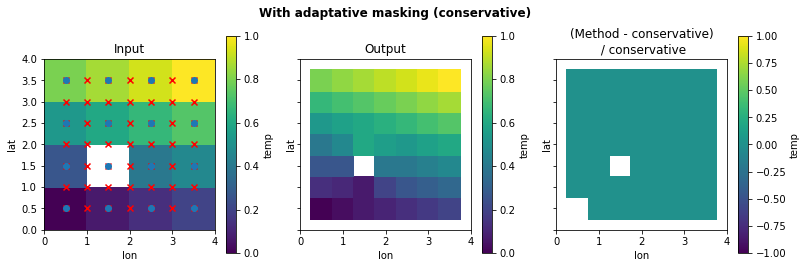

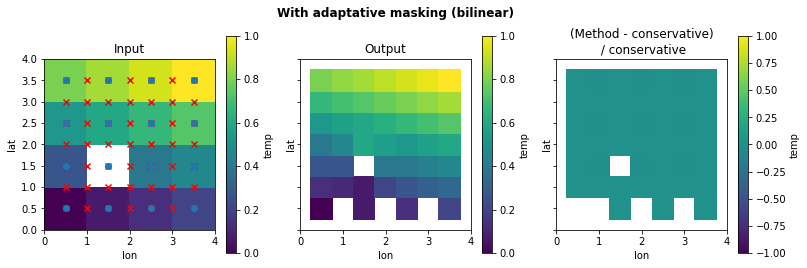

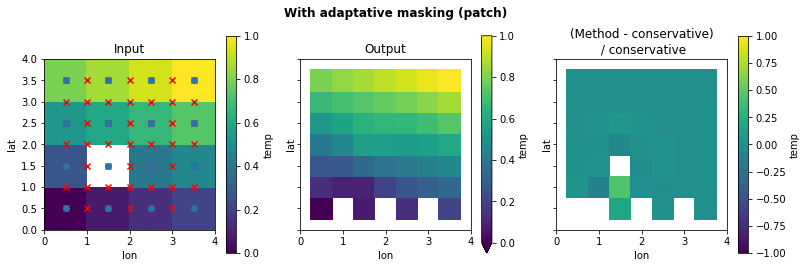

In [3]:
# Plot the differences

def triple_plot(da0, da1, da2, suptitle, title1='Input', title2='Output', 
                title3='(Method - conservative)\n / conservative',):
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharex=True, sharey=True,
                                   subplot_kw={'aspect': 1}, figsize=(13, 4))
    xi,yi = np.meshgrid(da0.lat.values, da0.lon.values)
    xo,yo = np.meshgrid(da1.lat.values, da1.lon.values)
    da0.plot(ax=ax0, add_colorbar=True, vmin=0, vmax=1)
    ax0.set_title(title1)
    #ax0.grid()
    ax0.scatter(xo,yo, marker="x", c="r")  
    ax0.scatter(xi,yi)
    da1.plot(ax=ax1, add_colorbar=True, vmin=0, vmax=1)
    ax1.set_title(title2)
    #ax1.scatter(xo,yo, marker="x", c="r")
    #ax1.scatter(xi,yi)
    #ax1.grid()
    da2.plot(ax=ax2, add_colorbar=True, vmin=-1, vmax=1)
    ax2.set_title(title3)
    #ax2.grid()
    plt.axis([0, 4, 0, 4])
    plt.suptitle(suptitle, weight="bold")
    plt.show() 

# Adaptative masking - conservative
rg = xe.Regridder(gridi, grido, method="conservative")
validi = dsi['temp'].notnull().astype('d')
valido = rg(validi)
tempi0 = dsi['temp'].fillna(0)
tempo0 = rg(tempi0)
tempomc = xr.where(valido != 0, tempo0 / valido, np.nan)
triple_plot(dsi['temp'], tempomc, (tempomc-tempomc)/tempomc, "With adaptative masking (conservative)")

# Adaptative masking - bilinear
#dsi['temp'].values[1,1]=1.
rg = xe.Regridder(gridi, grido, method="bilinear")
validi = dsi['temp'].notnull().astype('d')
valido = rg(validi)
tempi0 = dsi['temp'].fillna(0)
tempo0 = rg(tempi0)
tempomb = xr.where(valido != 0, tempo0 / valido, np.nan)
triple_plot(dsi['temp'], tempomb, (tempomb-tempomc)/tempomc, "With adaptative masking (bilinear)")

# Adaptative masking - patch
#dsi['temp'].values[1,1]=1.
rg = xe.Regridder(gridi, grido, method="patch")
validi = dsi['temp'].notnull().astype('d')
valido = rg(validi)
tempi0 = dsi['temp'].fillna(0)
tempo0 = rg(tempi0)
tempomp = xr.where(valido != 0, tempo0 / valido, np.nan)
triple_plot(dsi['temp'], tempomp, (tempomp-tempomc)/tempomc, "With adaptative masking (patch)")

#### Using a different example to further investigate the behavior at the southern domain boundary for patch/bilinear regridding

In the first row on the southern domain boundary, only the destination cells whose cell centers coincide with the source cell centers have a value. Else ESMF returns a missing value.

In [4]:
# Adjusted double plot function
def adj_double_plot(da0, da1, suptitle):
    fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, sharey=True,
                                   subplot_kw={'aspect': 1}, figsize=(16, 5))
    xi,yi = np.meshgrid(da0.lon.values, da0.lat.values)
    xo,yo = np.meshgrid(da1.lon.values, da1.lat.values)
    da0.plot(ax=ax0, add_colorbar=True, vmin=0, vmax=1)
    ax0.set_title('Input')
    #ax0.grid()
    ax0.scatter(xo,yo, marker="x", c="r")    
    ax0.scatter(xi,yi)    
    da1.plot(ax=ax1, add_colorbar=True, vmin=0, vmax=1)
    ax1.set_title('Output')
    #ax1.scatter(xo,yo, marker="x", c="r")  
    #ax1.scatter(xi,yi)
    #ax1.grid()
    plt.axis([0, 6, 0, 3])
    plt.suptitle(suptitle, weight="bold")
    plt.show()

In [5]:
# Input dataset
tempi = np.linspace(0,1,18).reshape(3,6)

dsi = xr.Dataset(
    {'temp': (['lat', 'lon'], tempi),
     'lon_b': ('nxb', [0., 1., 2., 3., 4., 5., 6.]),
     'lat_b': ('nyb', [0., 1., 2., 3.])},
    coords={'lat': [.5, 1.5, 2.5], 'lon': [.5, 1.5, 2.5, 3.5, 4.5, 5.5]})

# Input grid
gridi = xr.Dataset(
    {'lon_b': ('nxb', [0., 1., 2., 3., 4., 5., 6.]),
     'lat_b': ('nyb', [0., 1., 2., 3.])},
    coords={'lat': [.5, 1.5, 2.5], 'lon': [.5, 1.5, 2.5, 3.5, 4.5, 5.5]})

# Output grid
grido = xr.Dataset(
    {'lon_b': ('nxb', np.linspace(0.375, 5.625, 22)),
     'lat_b': ('nyb', np.linspace(0.375, 2.625, 10))},
    coords={'lat': np.linspace(0.5, 2.5, 9), 'lon': np.linspace(0.5, 5.5, 21)})

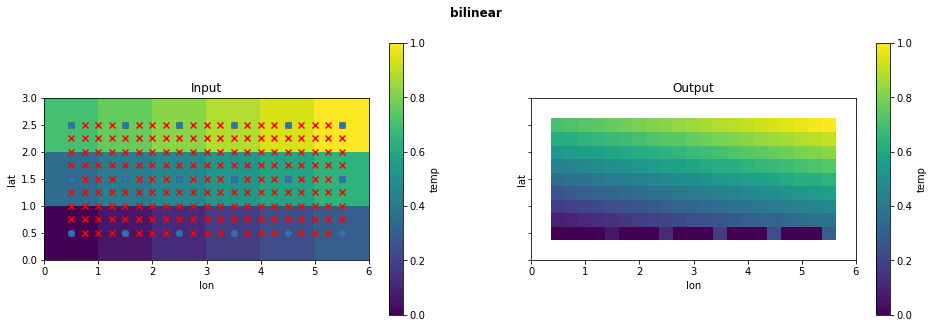

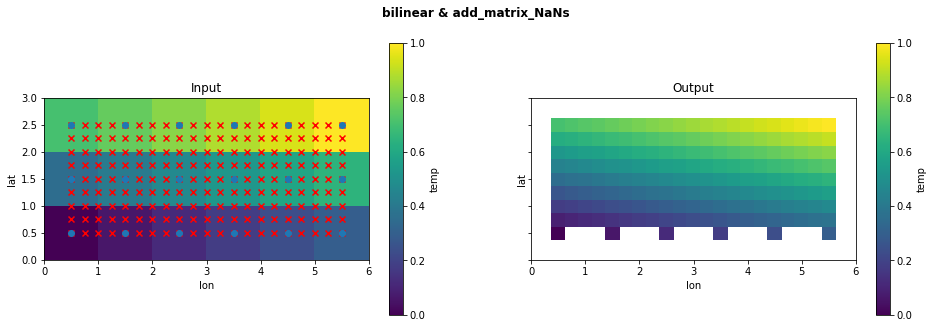

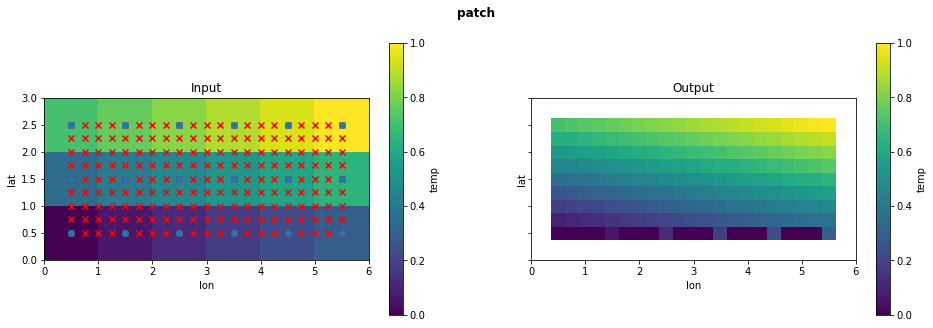

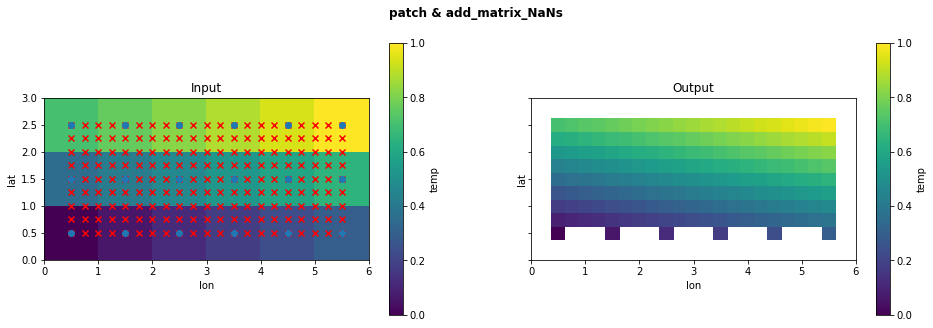

In [6]:
# Without any masking - bilinear
rg = xe.Regridder(gridi, grido, method="bilinear")
tempo = rg(dsi['temp'])
adj_double_plot(dsi['temp'], tempo, "bilinear")

# Input mask - bilinear, add_matrix_NaNs
rg = xe.Regridder(gridi, grido, method="bilinear")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
adj_double_plot(dsi['temp'], tempo, "bilinear & add_matrix_NaNs")


# Without any masking - patch
rg = xe.Regridder(gridi, grido, method="patch")
tempo = rg(dsi['temp'])
adj_double_plot(dsi['temp'], tempo, "patch")

# Input mask - patch, add_matrix_NaNs
rg = xe.Regridder(gridi, grido, method="patch")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
adj_double_plot(dsi['temp'], tempo, "patch & add_matrix_NaNs")

##### Moving cell centers of output grid to the east

leads to the entire row at the southern domain boundary getting missing values in the regridded data.

In [7]:
# Input dataset
tempi = np.linspace(0,1,18).reshape(3,6)

dsi = xr.Dataset(
    {'temp': (['lat', 'lon'], tempi),
     'lon_b': ('nxb', [0., 1., 2., 3., 4., 5., 6.]),
     'lat_b': ('nyb', [0., 1., 2., 3.])},
    coords={'lat': [.5, 1.5, 2.5], 'lon': [.5, 1.5, 2.5, 3.5, 4.5, 5.5]})

# Input grid
gridi = xr.Dataset(
    {'lon_b': ('nxb', [0., 1., 2., 3., 4., 5., 6.]),
     'lat_b': ('nyb', [0., 1., 2., 3.])},
    coords={'lat': [.5, 1.5, 2.5], 'lon': [.5, 1.5, 2.5, 3.5, 4.5, 5.5]})

# Output grid
grido = xr.Dataset(
    {'lon_b': ('nxb', np.linspace(0.375, 5.625, 22)+0.1),
     'lat_b': ('nyb', np.linspace(0.375, 2.625, 10))},
    coords={'lat': np.linspace(0.5, 2.5, 9), 'lon': np.linspace(0.5, 5.5, 21)+0.1})

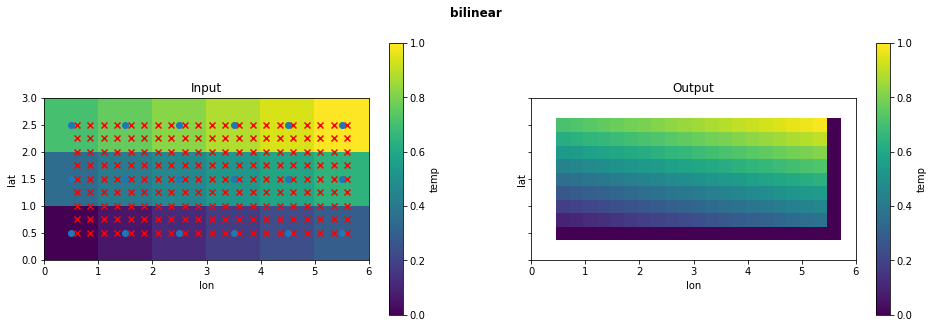

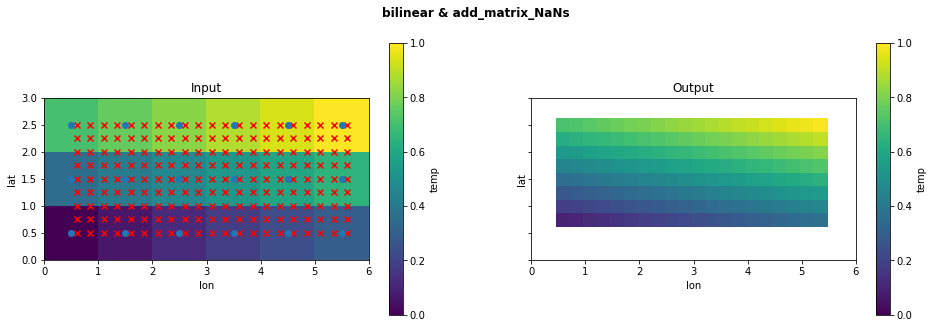

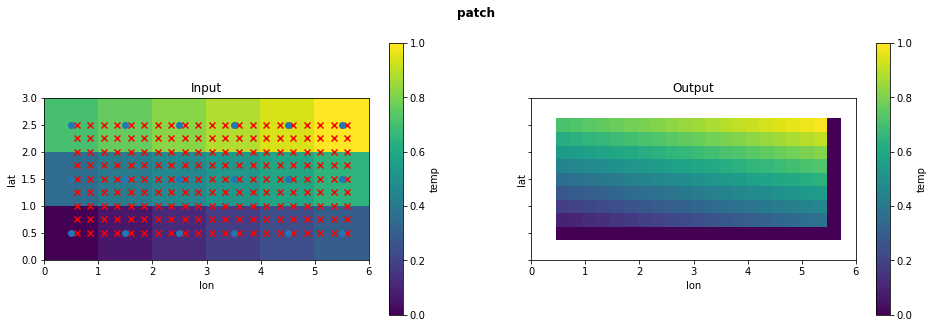

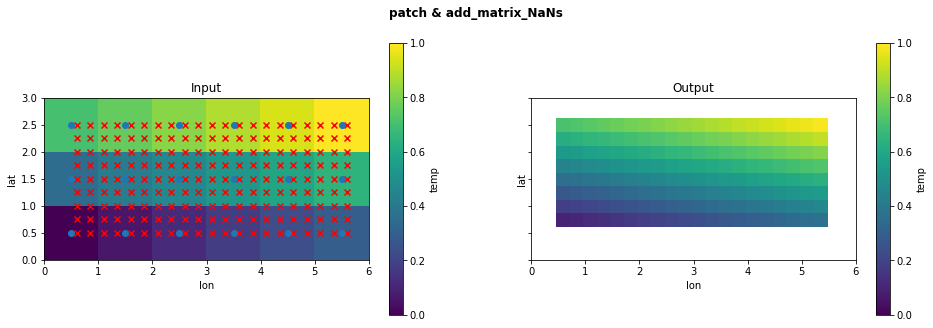

In [8]:
# Without any masking - bilinear
rg = xe.Regridder(gridi, grido, method="bilinear")
tempo = rg(dsi['temp'])
adj_double_plot(dsi['temp'], tempo, "bilinear")

# Input mask - bilinear, add_matrix_NaNs
rg = xe.Regridder(gridi, grido, method="bilinear")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
adj_double_plot(dsi['temp'], tempo, "bilinear & add_matrix_NaNs")


# Without any masking - patch
rg = xe.Regridder(gridi, grido, method="patch")
tempo = rg(dsi['temp'])
adj_double_plot(dsi['temp'], tempo, "patch")

# Input mask - patch, add_matrix_NaNs
rg = xe.Regridder(gridi, grido, method="patch")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
adj_double_plot(dsi['temp'], tempo, "patch & add_matrix_NaNs")

##### Defining cell centers and bounds as monotonically decreasing

does not change the location of the missing values in the regridded data.

In [9]:
# Input dataset
tempi = np.linspace(0,1,18).reshape(3,6)

dsi = xr.Dataset(
    {'temp': (['lat', 'lon'], tempi),
     'lon_b': ('nxb', [0., 1., 2., 3., 4., 5., 6.][::-1]),
     'lat_b': ('nyb', [0., 1., 2., 3.][::-1])},
    coords={'lat': [.5, 1.5, 2.5][::-1], 'lon': [.5, 1.5, 2.5, 3.5, 4.5, 5.5][::-1]})

# Input grid
gridi = xr.Dataset(
    {'lon_b': ('nxb', [0., 1., 2., 3., 4., 5., 6.][::-1]),
     'lat_b': ('nyb', [0., 1., 2., 3.][::-1])},
    coords={'lat': [.5, 1.5, 2.5][::-1], 'lon': [.5, 1.5, 2.5, 3.5, 4.5, 5.5][::-1]})

# Output grid
grido = xr.Dataset(
    {'lon_b': ('nxb', np.linspace(0.375, 5.625, 22)[::-1]),
     'lat_b': ('nyb', np.linspace(0.375, 2.625, 10)[::-1])},
    coords={'lat': np.linspace(0.5, 2.5, 9)[::-1], 'lon': np.linspace(0.5, 5.5, 21)[::-1]})

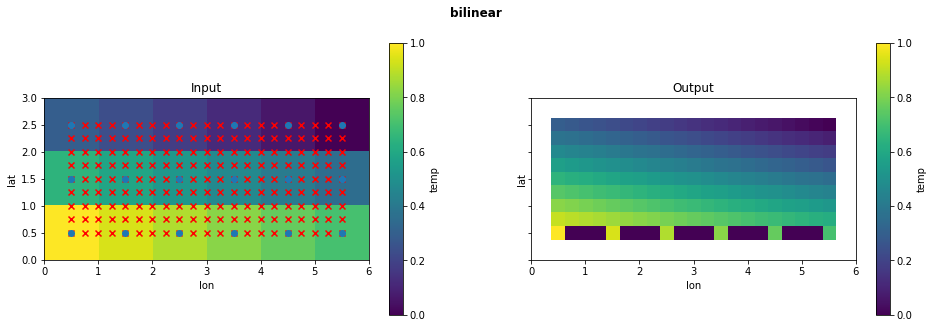

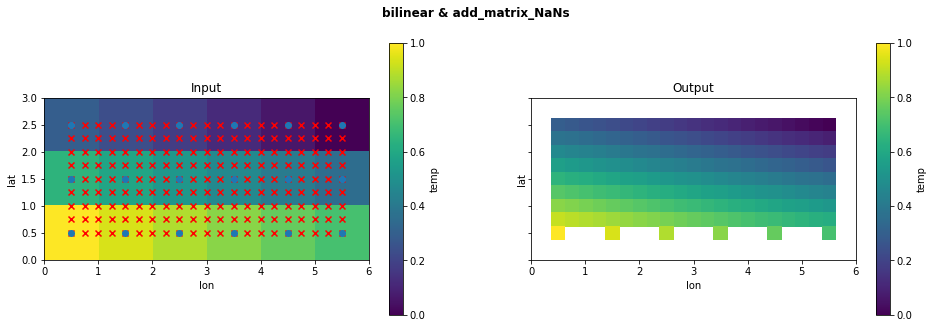

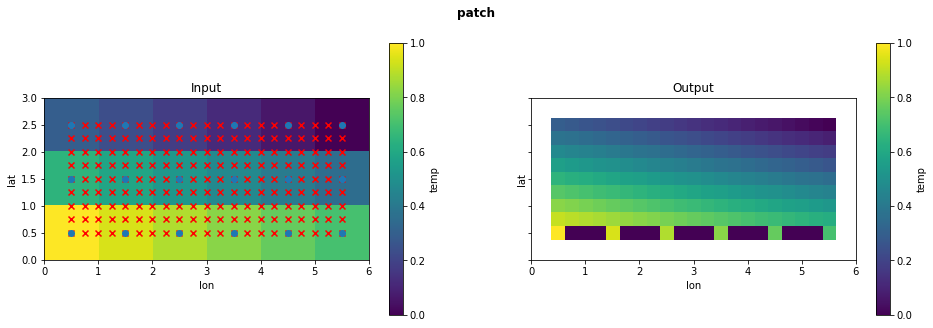

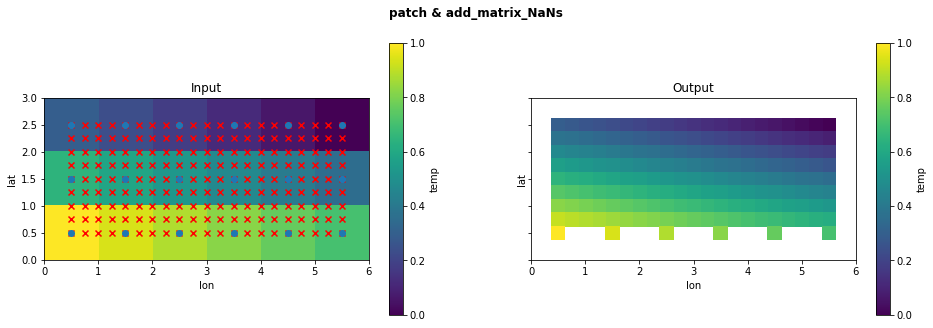

In [10]:
# Without any masking - bilinear
rg = xe.Regridder(gridi, grido, method="bilinear")
tempo = rg(dsi['temp'])
adj_double_plot(dsi['temp'], tempo, "bilinear")

# Input mask - bilinear, add_matrix_NaNs
rg = xe.Regridder(gridi, grido, method="bilinear")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
adj_double_plot(dsi['temp'], tempo, "bilinear & add_matrix_NaNs")


# Without any masking - patch
rg = xe.Regridder(gridi, grido, method="patch")
tempo = rg(dsi['temp'])
adj_double_plot(dsi['temp'], tempo, "patch")

# Input mask - patch, add_matrix_NaNs
rg = xe.Regridder(gridi, grido, method="patch")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
adj_double_plot(dsi['temp'], tempo, "patch & add_matrix_NaNs")

### Adaptive masking - Upscaling

#### Simply switching the input and output grid of the first / downscaling example 

Cell centers of source grid (left-hand-side) are depicted in blue.
Cell centers of the destination grid (right-hand-side) are depicted in red.

Conservative: Preserves the integral of the source field across the regridding.
For this method, weight calculation is based on the ratio of source cell area
overlapped with the corresponding destination cell area.


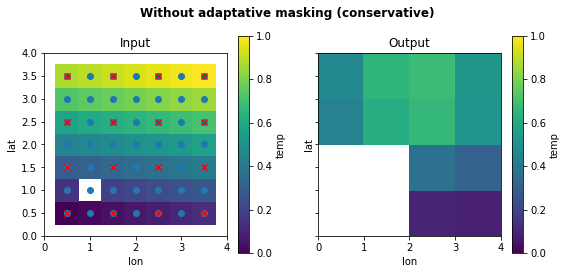

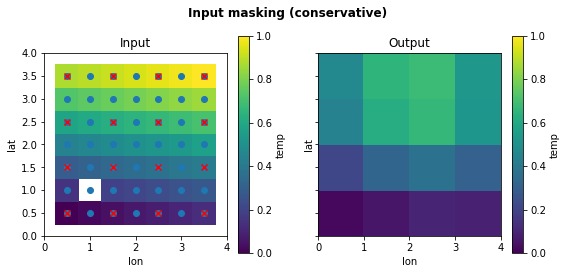

When using the conservative_normed technique and specifying an input mask, a renormalization is applied:


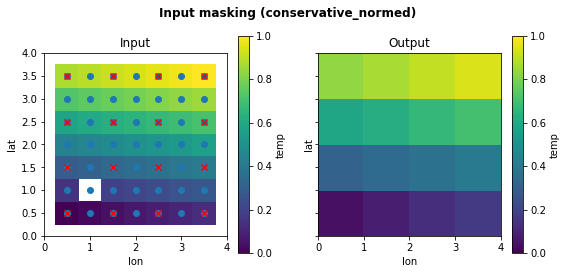

Additionally applying 'add_matrix_NaNs', masks the unwanted 0 values that ESMF returns in that case:


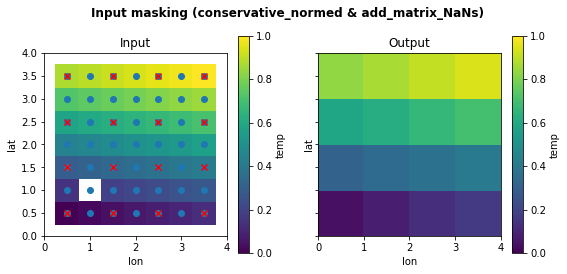

The same result is attained when using 'Adaptive Masking':


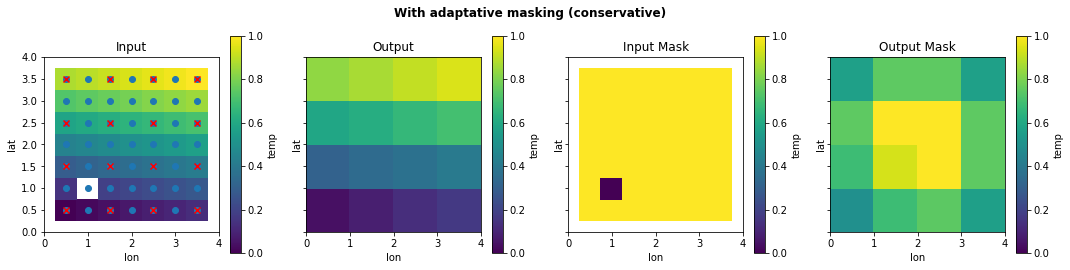

Bilinear: Linear interpolation in 2 or 3 dimensions.


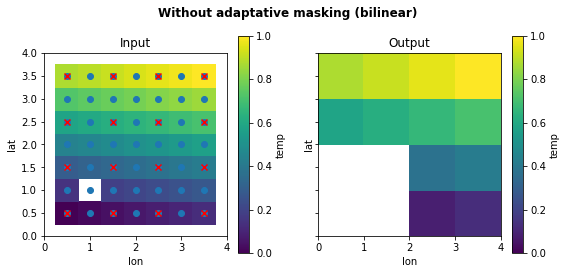

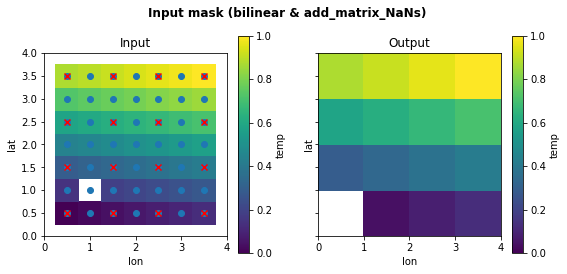

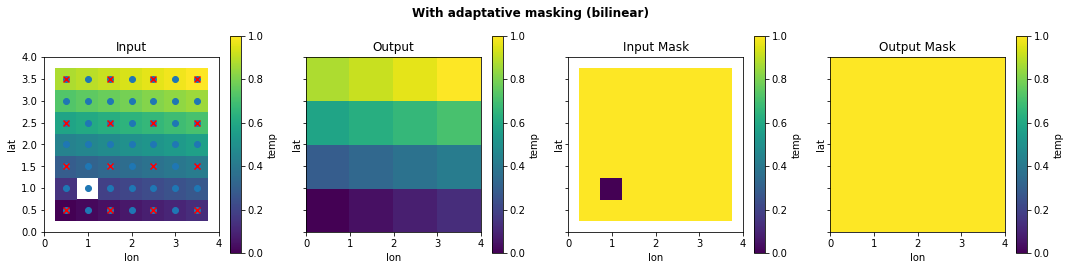

Patch: Patch rendezvous method of taking the least squares fit of the surrounding
surface patches. This is a higher order method that may produce interpolation
weights that may be slightly less than 0 or slightly greater than 1.


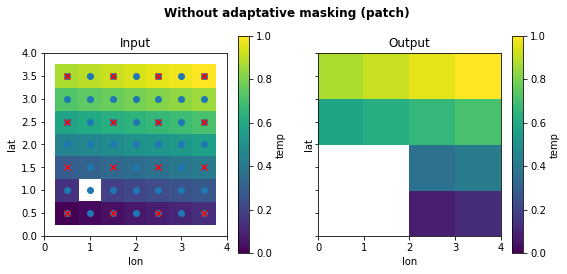

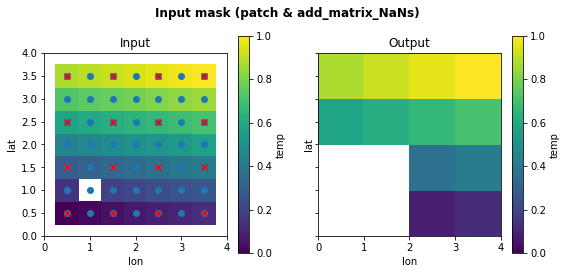

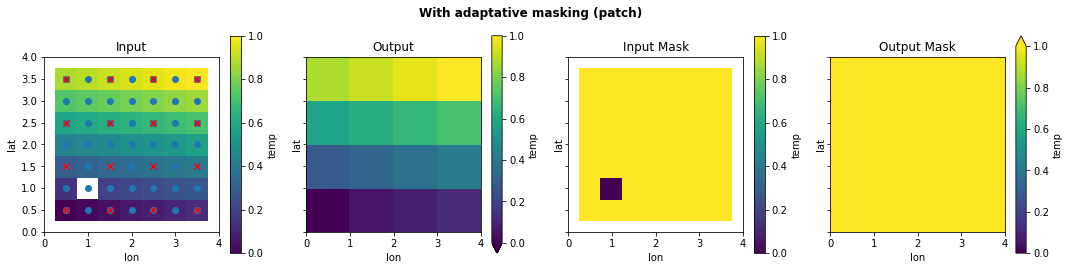

In [11]:
def double_plot(da0, da1, suptitle):
    fig, (ax0, ax1) = plt.subplots(ncols=2, sharex=True, sharey=True,
                                   subplot_kw={'aspect': 1}, figsize=(9, 4))
    xi,yi = np.meshgrid(da0.lon.values, da0.lat.values)
    xo,yo = np.meshgrid(da1.lon.values, da1.lat.values)
    da0.plot(ax=ax0, add_colorbar=True, vmin=0, vmax=1)
    ax0.set_title('Input')
    #ax0.grid()
    ax0.scatter(xi,yi)  
    ax0.scatter(xo,yo, marker="x", c="r")          
    da1.plot(ax=ax1, add_colorbar=True, vmin=0, vmax=1)
    ax1.set_title('Output')
    #ax1.scatter(xo,yo, marker="x", c="r")  
    #ax1.scatter(xi,yi)
    #ax1.grid()
    plt.axis([0, 4, 0, 4])
    plt.suptitle(suptitle, weight="bold")
    plt.show()

    
def quad_plot(da0, da1, da2, da3, suptitle, title1='Input', title2='Output', title3='Input Mask', title4='Output Mask'):
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, sharex=True, sharey=True,
                                   subplot_kw={'aspect': 1}, figsize=(18, 4))
    xi,yi = np.meshgrid(da0.lon.values, da0.lat.values)
    xo,yo = np.meshgrid(da1.lon.values, da1.lat.values)
    da0.plot(ax=ax0, add_colorbar=True, vmin=0, vmax=1)
    ax0.set_title(title1)
    #ax0.grid()
    ax0.scatter(xi,yi)
    ax0.scatter(xo,yo, marker="x", c="r")    
    da1.plot(ax=ax1, add_colorbar=True, vmin=0, vmax=1)
    ax1.set_title(title2)
    #ax1.scatter(xo,yo, marker="x", c="r")
    #ax1.scatter(xi,yi)
    #ax1.grid()
    da2.plot(ax=ax2, add_colorbar=True, vmin=0, vmax=1)
    ax2.set_title(title3)
    #ax2.grid()
    da3.plot(ax=ax3, add_colorbar=True, vmin=0, vmax=1)
    ax3.set_title(title4)
    #ax3.grid()
    plt.axis([0, 4, 0, 4])
    plt.suptitle(suptitle, weight="bold")
    plt.show()    
  
    
# Input dataset
tempi = np.linspace(0,1,49).reshape(7,7)
tempi[1, 1] = np.nan

dsi = xr.Dataset(
    {'temp': (['lat', 'lon'], tempi),
     'lon_b': ('nxb', [.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75]),
     'lat_b': ('nyb', [.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75])},
    coords={'lat': [.5, 1., 1.5, 2., 2.5, 3., 3.5], 'lon': [.5, 1., 1.5, 2., 2.5, 3., 3.5]})

# Input grid
gridi = xr.Dataset(
    {'lon_b': ('nxb', [.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75]),
     'lat_b': ('nyb', [.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75])},
    coords={'lat': [.5, 1., 1.5, 2., 2.5, 3., 3.5], 'lon': [.5, 1., 1.5, 2., 2.5, 3., 3.5]})

# Input grid (incl. mask)
gridi_masked = xr.Dataset(
    {'mask': (('lat', 'lon'), dsi['temp'].notnull()), 
     'lon_b': ('nxb', [.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75]),
     'lat_b': ('nyb', [.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75])},
    coords={'lat': [.5, 1., 1.5, 2., 2.5, 3., 3.5], 'lon': [.5, 1., 1.5, 2., 2.5, 3., 3.5]})

# Output grid
grido = xr.Dataset(
    {'lon_b': ('nxb', [0., 1., 2., 3., 4.]),
     'lat_b': ('nyb', [0., 1., 2., 3., 4.])},
    coords={'lat': [.5, 1.5, 2.5, 3.5], 'lon': [.5, 1.5, 2.5, 3.5]})  


# Regridding
# ----------

# Without any masking - conservative
rg = xe.Regridder(gridi, grido, method="conservative")
tempo = rg(dsi['temp'])
print("Cell centers of source grid (left-hand-side) are depicted in blue.")
print("Cell centers of the destination grid (right-hand-side) are depicted in red.\n")
print("Conservative: Preserves the integral of the source field across the regridding.\n"
      "For this method, weight calculation is based on the ratio of source cell area\n"
      "overlapped with the corresponding destination cell area.")
double_plot(dsi['temp'], tempo, "Without adaptative masking (conservative)")

# Input masking - conservative
rg = xe.Regridder(gridi_masked, grido, method="conservative")
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input masking (conservative)")

# Input masking - conservative normed
print("When using the conservative_normed technique and specifying an input mask,"
      " a renormalization is applied:")
rg = xe.Regridder(gridi_masked, grido, method="conservative_normed")
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input masking (conservative_normed)")

# Input masking - conservative normed, add_matrix_NaNs
print("Additionally applying 'add_matrix_NaNs', masks the unwanted 0 values that ESMF returns in that case:")
rg = xe.Regridder(gridi_masked, grido, method="conservative_normed")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input masking (conservative_normed & add_matrix_NaNs)")

# Adaptative masking - conservative
print("The same result is attained when using 'Adaptive Masking':")
rg = xe.Regridder(gridi, grido, method="conservative")
validi = dsi['temp'].notnull().astype('d')
valido = rg(validi)
tempi0 = dsi['temp'].fillna(0)
tempo0 = rg(tempi0)
tempom = xr.where(valido != 0, tempo0 / valido, np.nan)
quad_plot(dsi['temp'], tempom, validi, valido, "With adaptative masking (conservative)")


# Without any masking - bilinear
rg = xe.Regridder(gridi, grido, method="bilinear")
tempo = rg(dsi['temp'])
print("Bilinear: Linear interpolation in 2 or 3 dimensions.")
double_plot(dsi['temp'], tempo, "Without adaptative masking (bilinear)")

# Input mask - bilinear, add_matrix_NaNs
rg = xe.Regridder(gridi_masked, grido, method="bilinear")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input mask (bilinear & add_matrix_NaNs)")

# Adaptative masking - bilinear
rg = xe.Regridder(gridi, grido, method="bilinear")
validi = dsi['temp'].notnull().astype('d')
valido = rg(validi)
tempi0 = dsi['temp'].fillna(0)
tempo0 = rg(tempi0)
tempom = xr.where(valido != 0, tempo0 / valido, np.nan)
quad_plot(dsi['temp'], tempom, validi, valido, "With adaptative masking (bilinear)")


# Without any masking - patch
rg = xe.Regridder(gridi, grido, method="patch")
tempo = rg(dsi['temp'])
print("Patch: Patch rendezvous method of taking the least squares fit of the surrounding\n"
      "surface patches. This is a higher order method that may produce interpolation\n" 
      "weights that may be slightly less than 0 or slightly greater than 1.")
double_plot(dsi['temp'], tempo, "Without adaptative masking (patch)")

# Input mask - patch, add_matrix_NaNs
rg = xe.Regridder(gridi_masked, grido, method="patch")
rg = add_matrix_NaNs(rg)
tempo = rg(dsi['temp'])
double_plot(dsi['temp'], tempo, "Input mask (patch & add_matrix_NaNs)")

# Adaptative masking - patch
rg = xe.Regridder(gridi, grido, method="patch")
validi = dsi['temp'].notnull().astype('d')
valido = rg(validi)
tempi0 = dsi['temp'].fillna(0)
tempo0 = rg(tempi0)
tempom = xr.where(valido != 0, tempo0 / valido, np.nan)
quad_plot(dsi['temp'], tempom, validi, valido, "With adaptative masking (patch)")